Modelo inicial comparado no report

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
# Data directories
train_data_dir = 'Data/train'
validation_data_dir = 'Data/test'
img_height, img_width = 224, 224
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Model building
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the checkpoint callback
checkpoint_filepath = 'best_model5.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)


Found 17753 images belonging to 10 classes.
Found 4440 images belonging to 10 classes.


In [3]:
# Model training with checkpoint callback
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)


Epoch 1/10


C:\Users\diana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


555/555 ━━━━━━━━━━━━━━━━━━━━ 847s 2s/step - accuracy: 0.2530 - loss: 2.1642 - val_accuracy: 0.3284 - val_loss: 1.8949
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 819s 1s/step - accuracy: 0.3406 - loss: 1.8326 - val_accuracy: 0.3167 - val_loss: 1.7875
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 821s 1s/step - accuracy: 0.3921 - loss: 1.6981 - val_accuracy: 0.3286 - val_loss: 1.8475
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - accuracy: 0.4327 - loss: 1.6075 - val_accuracy: 0.3297 - val_loss: 1.8167
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - accuracy: 0.4605 - loss: 1.5281 - val_accuracy: 0.4194 - val_loss: 1.6536
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 822s 1s/step - accuracy: 0.4821 - loss: 1.4705 - val_accuracy: 0.4768 - val_loss: 1.4814
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 829s 1s/step - accuracy: 0.5077 - loss: 1.4217 - val_accuracy: 0.3849 - val_loss: 1.6476
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - accuracy: 0.5114 - loss: 1.3907 - val_accuracy: 0.410

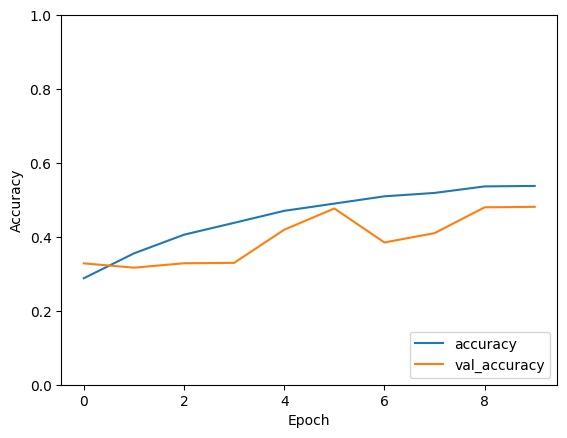

In [4]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


parte dois - integração com CSV e imagem para análise

In [11]:
import cv2
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

In [19]:
# Load the best saved model
best_model = load_model('best_model5.keras')

In [16]:
import cv2

def predict_disease(image_path, model, class_indices, csv_file):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_height, img_width))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)
    
    class_labels = {v: k for k, v in class_indices.items()}
    disease = class_labels[predicted_class[0]]
    
    recommendations = pd.read_csv(csv_file)
    treatments = recommendations.loc[recommendations['disease'] == disease, ['product', 'dose', 'IS']]

    return disease, treatments

In [17]:
# Test the prediction function
csv_file = 'products2.csv'
class_indices = train_generator.class_indices

image_path = 'mosaico.jpg'
disease, treatments = predict_disease(image_path, model, class_indices, csv_file)
print(f"Disease: {disease}")
print("Treatments:")
for _, row in treatments.iterrows():
    print(f"Product: {row['product']}, Dose: {row['dose']}, IS: {row['IS']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Disease: mosaic_virus
Treatments:
Product: V10, Dose: 70 L/ha, IS: - / -
Product: V10, Dose: 0,8 L/ha, IS: - / -


In [27]:
# Test the prediction function
csv_file = 'products2.csv'
class_indices = train_generator.class_indices

image_path = 'late_b.jpg'
disease, treatments = predict_disease(image_path, model, class_indices, csv_file)
print(f"Disease: {disease}")
print("Treatments:")
for _, row in treatments.iterrows():
    print(f"Product: {row['product']}, Dose: {row['dose']}, IS: {row['IS']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Disease: septoria_leaf_spot
Treatments:
Product: FOLPETIS, Dose:  - 2 kg/ha, IS: 7 / -
Product: FOLPETIS, Dose:  - 1,5 kg/ha, IS: 7 / -
Product: FOLPEC 50 SC, Dose:  - 3,2 L/ha, IS: 7 / -
Product: FOLPEC 50 SC, Dose:  - 2,5 L/ha, IS: 7 / -
Product: FOLPEC 80 WG, Dose:  - 1,5 kg/ha, IS: 7 / -
Product: FOLPEC 80 WG, Dose:  - 2 kg/ha, IS: 7 / -
Product: FOLPETIS SC, Dose:  - 3,2 L/ha, IS: 7 / -
Product: FOLPETIS SC, Dose:  - 2,5 L/ha, IS: 7 / -


Avaliar o modelo inicial

In [23]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model('best_model5.keras')

# Define the validation/test directory
validation_dir = 'Data/test'

# Image data generator for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

# Get the true labels
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Predict the probabilities
predictions = model.predict(validation_generator)

# Get the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)


Found 4440 images belonging to 10 classes.


C:\Users\diana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/139 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step


Confusion Matrix do modelo inicial

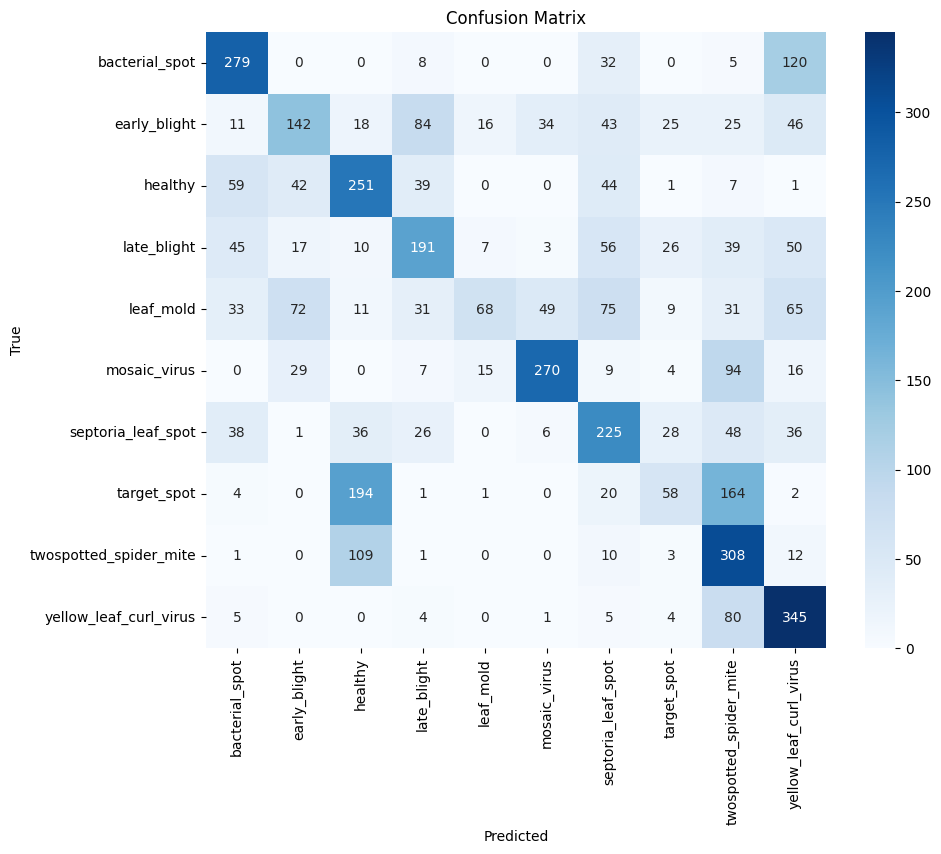

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_class_indices)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Metricas de performance do modelo inicial

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Accuracy
accuracy = accuracy_score(true_labels, predicted_class_indices)
print(f'Accuracy: {accuracy:.4f}')

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_class_indices, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Detailed Classification Report
report = classification_report(true_labels, predicted_class_indices, target_names=class_labels)
print(report)


Accuracy: 0.4813
Precision: 0.5005
Recall: 0.4813
F1-Score: 0.4590
                        precision    recall  f1-score   support

        bacterial_spot       0.59      0.63      0.61       444
          early_blight       0.47      0.32      0.38       444
               healthy       0.40      0.57      0.47       444
           late_blight       0.49      0.43      0.46       444
             leaf_mold       0.64      0.15      0.25       444
          mosaic_virus       0.74      0.61      0.67       444
    septoria_leaf_spot       0.43      0.51      0.47       444
           target_spot       0.37      0.13      0.19       444
twospotted_spider_mite       0.38      0.69      0.49       444
yellow_leaf_curl_virus       0.50      0.78      0.61       444

              accuracy                           0.48      4440
             macro avg       0.50      0.48      0.46      4440
          weighted avg       0.50      0.48      0.46      4440



Class Weights do modelo inicial

In [26]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(true_labels), y=true_labels)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}
print('Class Weights:', class_weight_dict)


Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}


Melhorando o modelo inicial, para chegar ao modelo final

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os


In [34]:

# Define directories with raw strings to handle backslashes properly
train_dir = r'Data\train'
validation_dir = r'Data\test'

# Check if the directories exist
assert os.path.exists(train_dir), f"Training directory does not exist: {train_dir}"
assert os.path.exists(validation_dir), f"Validation directory does not exist: {validation_dir}"

# Image data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 17753 images belonging to 10 classes.
Found 4440 images belonging to 10 classes.


In [35]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Load the ResNet50 model with pre-trained weights
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers in the base model
for layer in resnet50_base.layers[-40:]:
    layer.trainable = True

# Build the model
model = Sequential([
    resnet50_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),  #first dense layer 512
    Dropout(0.5),
    Dense(256, activation='relu'),  #second dense layer 256
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  #output layer 10 classes
])


In [36]:

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_tomato_disease_model.keras', monitor='val_loss', save_best_only=True)


In [37]:

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)

# Save the model
model.save('final_tomato_disease_model.keras')


Epoch 1/50


C:\Users\diana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


554/554 ━━━━━━━━━━━━━━━━━━━━ 3280s 6s/step - accuracy: 0.5888 - loss: 1.2561 - val_accuracy: 0.0804 - val_loss: 3.2935
Epoch 2/50
  1/554 ━━━━━━━━━━━━━━━━━━━━ 50:43 6s/step - accuracy: 0.9062 - loss: 0.2789

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


554/554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9062 - loss: 0.2789 - val_accuracy: 0.0000e+00 - val_loss: 3.9625
Epoch 3/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 3244s 6s/step - accuracy: 0.9286 - loss: 0.2556 - val_accuracy: 0.8048 - val_loss: 0.8160
Epoch 4/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 1.0000 - loss: 0.0751 - val_accuracy: 0.8750 - val_loss: 0.4168
Epoch 5/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 3251s 6s/step - accuracy: 0.9488 - loss: 0.1759 - val_accuracy: 0.9588 - val_loss: 0.1181
Epoch 6/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8750 - loss: 0.2250 - val_accuracy: 1.0000 - val_loss: 0.0195
Epoch 7/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 3245s 6s/step - accuracy: 0.9554 - loss: 0.1487 - val_accuracy: 0.9094 - val_loss: 0.3363
Epoch 8/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9688 - loss: 0.0822 - val_accuracy: 0.7083 - val_loss: 0.5204
Epoch 9/50
554/554 ━━━━━━━━━━━━━━━━━━━━ 3249s 6s/step - accuracy: 0.9649 - loss: 0.1133 - val_accuracy: 0

Found 4440 images belonging to 10 classes.


C:\Users\diana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/139 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step


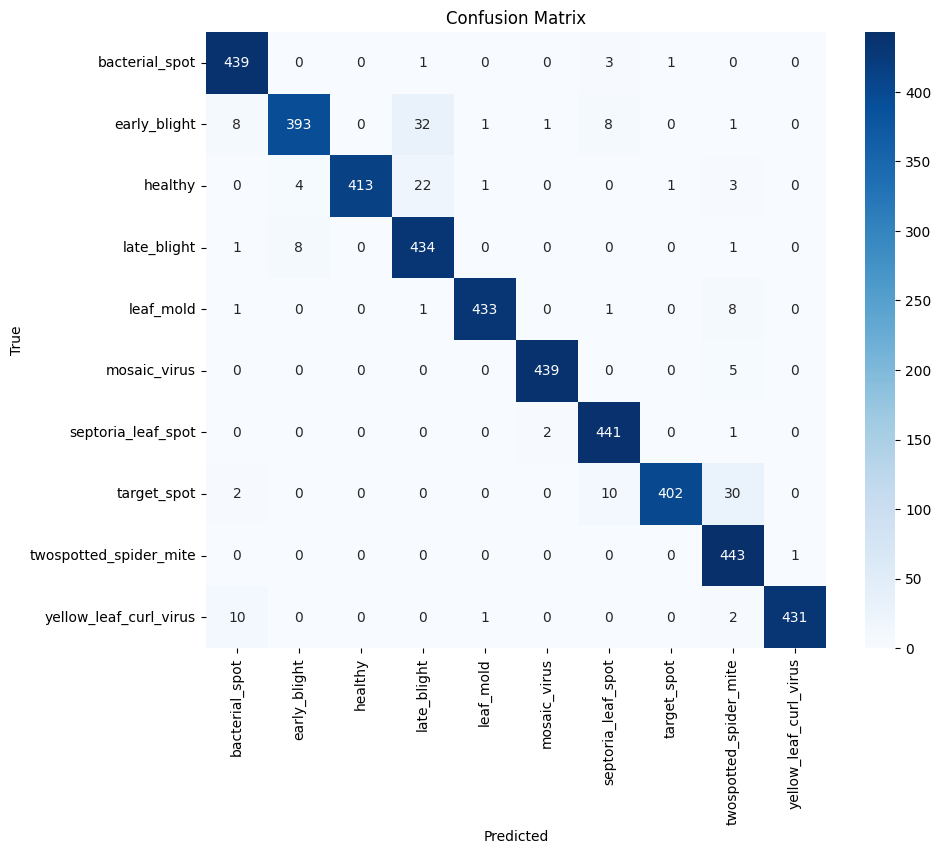

                        precision    recall  f1-score   support

        bacterial_spot       0.95      0.99      0.97       444
          early_blight       0.97      0.89      0.93       444
               healthy       1.00      0.93      0.96       444
           late_blight       0.89      0.98      0.93       444
             leaf_mold       0.99      0.98      0.98       444
          mosaic_virus       0.99      0.99      0.99       444
    septoria_leaf_spot       0.95      0.99      0.97       444
           target_spot       1.00      0.91      0.95       444
twospotted_spider_mite       0.90      1.00      0.94       444
yellow_leaf_curl_virus       1.00      0.97      0.98       444

              accuracy                           0.96      4440
             macro avg       0.96      0.96      0.96      4440
          weighted avg       0.96      0.96      0.96      4440

Accuracy: 0.9613
Precision: 0.9637
Recall: 0.9613
F1-Score: 0.9613


In [39]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = load_model('final_tomato_disease_model.keras')

# Define the validation/test directory
validation_dir = r'Data\test'

# Image data generator for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

# Get the true labels
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Predict the probabilities
predictions = model.predict(validation_generator)

# Get the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_class_indices)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_labels, predicted_class_indices, target_names=class_labels)
print(report)

# Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(true_labels, predicted_class_indices)
precision = precision_score(true_labels, predicted_class_indices, average='weighted')
recall = recall_score(true_labels, predicted_class_indices, average='weighted')
f1 = f1_score(true_labels, predicted_class_indices, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


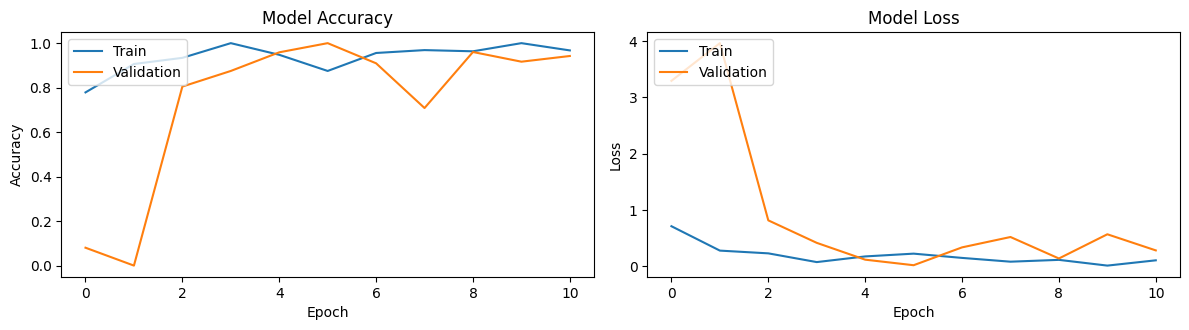

In [58]:
import matplotlib.pyplot as plt
best_model = load_model('final_tomato_disease_model.keras')
# Function to plot training and validation metrics
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    
    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_metrics(history)

Verificar recomendações com o modelo final

In [50]:
import cv2
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
# Load the best saved model
best_model = load_model('final_tomato_disease_model.keras')

import cv2

def predict_disease(image_path, model, class_indices, csv_file):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_height, img_width))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)
    
    class_labels = {v: k for k, v in class_indices.items()}
    disease = class_labels[predicted_class[0]]
    
    recommendations = pd.read_csv(csv_file)
    treatments = recommendations.loc[recommendations['disease'] == disease, ['product', 'dose', 'IS']]

    return disease, treatments

In [52]:
# Test the prediction function
csv_file = 'products2.csv'
class_indices = train_generator.class_indices

image_path = 'mold2.jpg'
disease, treatments = predict_disease(image_path, model, class_indices, csv_file)
print(f"Disease: {disease}")
print("Treatments:")
for _, row in treatments.iterrows():
    print(f"Product: {row['product']}, Dose: {row['dose']}, IS: {row['IS']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Disease: leaf_mold
Treatments:
Product: SCORE 250 EC, Dose:  - 500 mL/ha, IS: 7 / -
Product: ZANOL, Dose:  - 500 mL/ha, IS: 7 / -
Product: MAVITA 250 EC, Dose:  - 500 mL/ha, IS: 7 / -
Product: DAGONIS, Dose: 1 L/ha, IS: 3 / -
Product: GALAVIO, Dose:  - 500 mL/ha, IS: 7 / -
Product: DIZOLE, Dose:  - 500 mL/ha, IS: 7 / -
Product: BLIN 25 EC, Dose:  - 500 mL/ha, IS: 7 / -
Product: DIFENOFIN, Dose: 250 - 500 mL/ha, IS: 7 / -
